### MCMC logspace comparison

This notebook compares the MCMC algorithm in logspace vs sampling from a normal distribution and passing exp(sample) to the model. 

The hyperparameters are chosen as follows:
$\sigma_{pr} = 2$, $\sigma = 0.05$, $\sigma_{prop} = 0.0725$.

#### Benchmark:
*  __Forward model__ $\Phi$:  Takes positive stiffness values $\theta \in \mathbb{R}_+^{64}$, the forward pass computes $\Phi(\theta)$.

* __Prior__  $\pi_{pr}(\theta) = \prod_{k=0}^{63} exp(-\frac{(ln(\theta_k)-ln(1))^2}{2\sigma_{pr}^2})$

* __Likelihood__ $L(z|\theta) = \prod_{k=0}^{168} exp(-\frac{(z_k-\Phi(\theta)_k)^2}{2\sigma^2})$

* __Proposal__: Draw proposal $\tilde{\theta}_i \in \mathbb{R}_+^{64}$ according to $\tilde{\theta}_{i,k} = exp(ln(\theta_{i,k})+\xi_k)$ where $\xi_k \sim \mathcal{N}(0,\sigma_{prop}^2) $


#### Not logspace:
The interpretation is now that we draw samples  $x_i \in \mathbb{R}^{64}$ and pass $\exp(x_i)$ to the model. Therefore $x_i = log(\theta_i)$.
* __Forward model__ $\Phi$:  Takes 'stiffness' values $x \in \mathbb{R}^{64}$, the forward pass computes $\Phi(\exp(x))$

* __Prior__  $\pi_{pr}(x) = \prod_{k=0}^{63} exp(-\frac{(x_k)^2}{2\sigma_{pr}^2})$

* __Likelihood__ $L(z|x) = \prod_{k=0}^{168} exp(-\frac{(z_k-\Phi(\exp(x))_k)^2}{2\sigma^2})$

* __Proposal__: Draw proposal $\tilde{x}_i \in \mathbb{R}^{64}$ according to $\tilde{x}_i \sim \mathcal{N}(x_i, \sigma_{prop}^2)$ i.e. standard Gaussian random walk.

Since this approach samples in the whole space $\mathbb{R}^{64}$ we hope that $\exp(x_i) \sim \pi_{post}$.




In [2]:
#%matplotlib widget

import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.stats import multivariate_normal, rv_continuous
from scipy.spatial import distance_matrix
import scipy.io
import tinyDA as tda
from tinyDA import Proposal
import umbridge
import arviz as az
import pandas as pd
import pickle 
import seaborn as sns


### Load data

In [3]:
plot_log_theta = False # if true log(theta) vs x is drawn if false theta vs exp(x) is drawn

# load data arviz inference data
chains_not_logspace = az.from_json('MCMC_chains_not_logspace\MCMC_chains_length_200000_numChains_2_h_1_32.json')
if not plot_log_theta:
    chains_not_logspace = chains_not_logspace.map(lambda x: np.exp(x))
# compute statistics
summary_not_logspace = az.summary(chains_not_logspace)

chains_MCMC = az.from_json('MCMC_chains\MCMC_chains_length_200000_numChains_2_h_1_32.json')
if plot_log_theta:
    chains_MCMC = chains_MCMC.map(lambda x: np.log(x))
summary_MCMC = az.summary(chains_MCMC)

# load chains that are stored in a dictionary
with open('MCMC_chains_not_logspace\MCMC_chains_dict_length_200000_numChains_2_h_1_32.pkl', 'rb') as f:
    chains_not_logspace_dict = pickle.load(f)
if not plot_log_theta:
    for n in range(chains_not_logspace_dict['n_chains']):
        chains_not_logspace_dict['chain_%d'%n] = np.exp(chains_not_logspace_dict['chain_%d'%n])

with open('MCMC_chains\MCMC_chains_dict_length_200000_numChains_2_h_1_32.pkl', 'rb') as f:
    chains_MCMC_dict = pickle.load(f)
if plot_log_theta:
    for n in range(chains_MCMC_dict['n_chains']):
        chains_MCMC_dict['chain_%d'%n] = np.log(chains_MCMC_dict['chain_%d'%n])

In [66]:
summary_not_logspace

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta_0,2.062,6.892,0.073,4.395,0.614,0.435,103.0,200.0,1.01
theta_1,1.110,0.689,0.194,2.282,0.045,0.032,216.0,555.0,1.01
theta_2,1.035,0.479,0.238,1.909,0.029,0.020,250.0,408.0,1.01
theta_3,0.945,0.394,0.238,1.667,0.025,0.017,250.0,646.0,1.01
theta_4,1.019,0.464,0.241,1.881,0.032,0.022,208.0,386.0,1.01
...,...,...,...,...,...,...,...,...,...
theta_59,1.005,0.514,0.131,1.888,0.037,0.026,169.0,386.0,1.01
theta_60,1.138,0.626,0.142,2.242,0.058,0.041,98.0,431.0,1.04
theta_61,0.993,0.718,0.083,2.339,0.071,0.051,96.0,383.0,1.02
theta_62,1.036,0.772,0.087,2.431,0.076,0.054,94.0,393.0,1.02


In [67]:
summary_MCMC

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta_0,201.426,976.337,0.064,711.653,140.074,99.648,19.0,36.0,1.11
theta_1,1.035,0.812,0.164,2.224,0.049,0.035,183.0,549.0,1.02
theta_2,1.002,0.428,0.289,1.804,0.022,0.016,369.0,907.0,1.00
theta_3,0.876,0.337,0.296,1.511,0.014,0.010,548.0,1185.0,1.00
theta_4,0.966,0.407,0.270,1.709,0.020,0.014,414.0,884.0,1.00
...,...,...,...,...,...,...,...,...,...
theta_59,1.052,0.470,0.225,1.898,0.025,0.018,318.0,631.0,1.01
theta_60,0.940,0.527,0.136,1.859,0.028,0.020,329.0,778.0,1.01
theta_61,0.917,0.527,0.142,1.900,0.028,0.020,317.0,672.0,1.00
theta_62,0.962,0.595,0.110,2.035,0.036,0.026,247.0,517.0,1.02


### Plot paths:

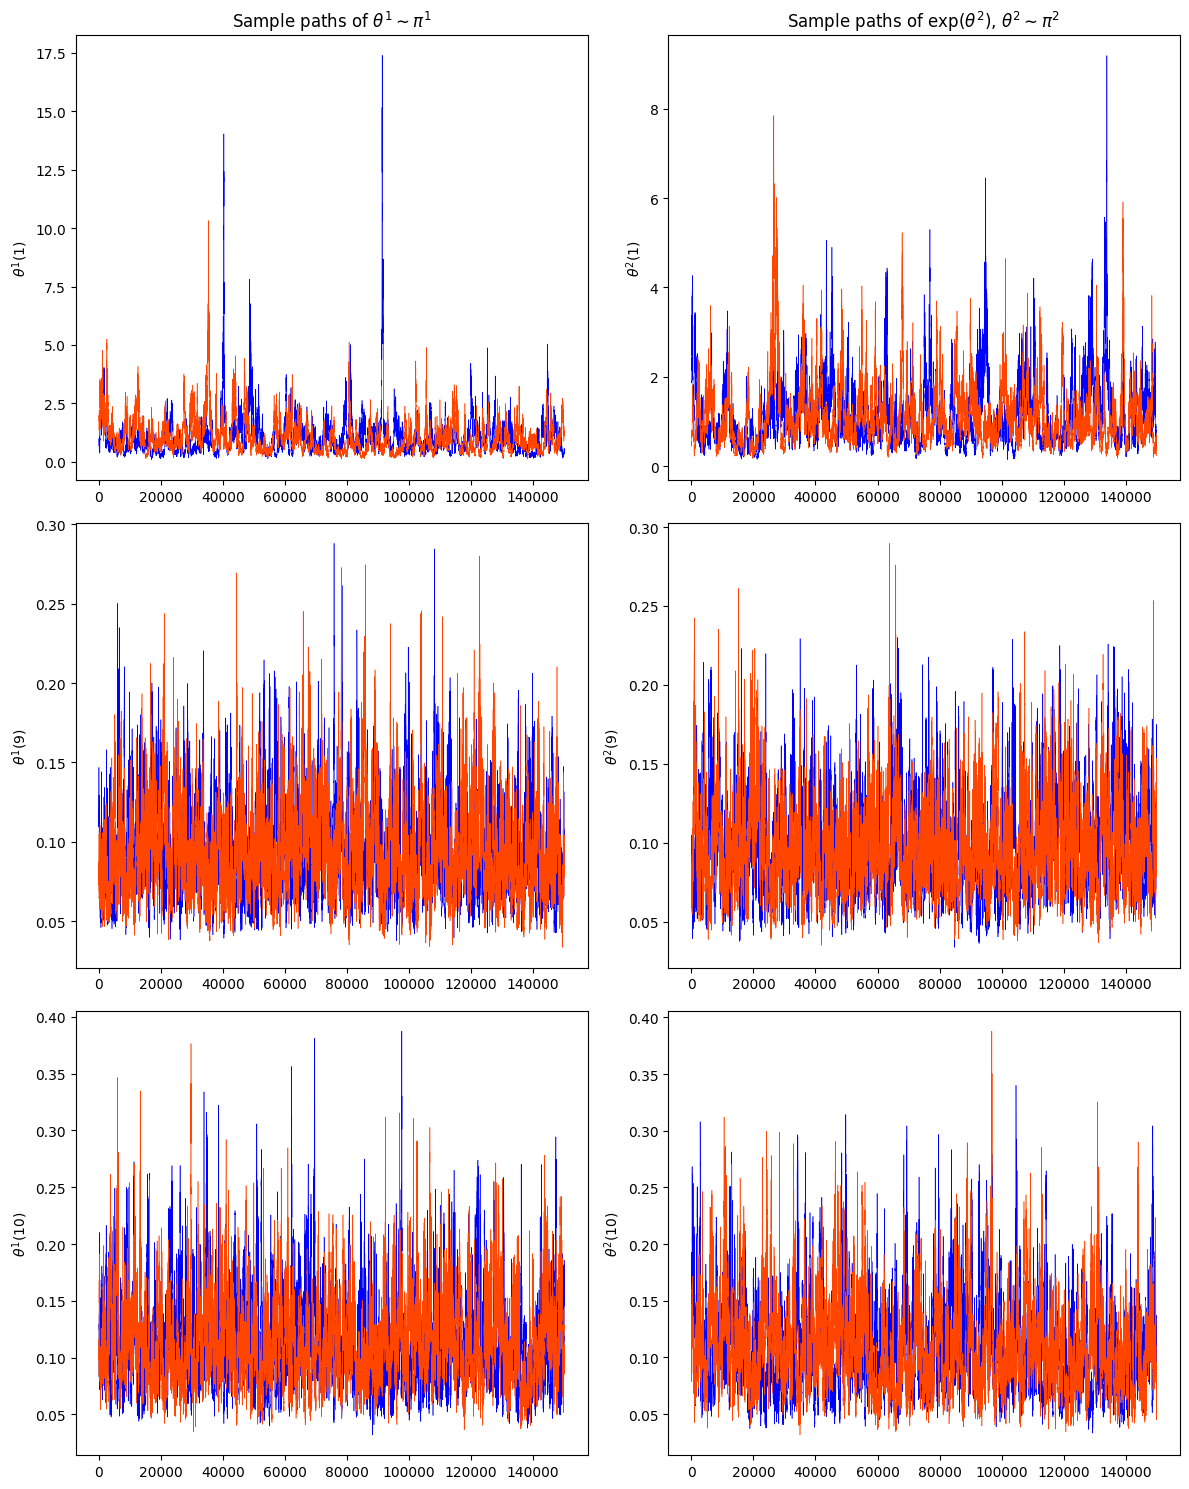

In [6]:
path_indices = [1,9,10] # select the indices of theta you would like to plot (i = 0,...,63 allowed)

fig ,axs = plt.subplots(nrows=len(path_indices), ncols=2, figsize=(12,15))

for idx, i in enumerate(path_indices):
    axs[idx,0].plot(chains_MCMC_dict['chain_0'][:,i],'b', linewidth=0.4)
    axs[idx,0].plot(chains_MCMC_dict['chain_1'][:,i], 'orangered', linewidth=0.4)
    axs[idx,1].plot(chains_not_logspace_dict['chain_0'][:,i],'b', linewidth=0.4)
    axs[idx,1].plot(chains_not_logspace_dict['chain_1'][:,i], 'orangered', linewidth=0.4)
    axs[idx,0].set_ylabel(r'$\theta^1(%d)$'%i)
    axs[idx,1].set_ylabel(r'$\theta^2(%d)$'%i)

axs[0,0].set_title(r"Sample paths of $\theta^1 \sim \pi^1$")
axs[0,1].set_title(r'Sample paths of $\exp(\theta^2)$, $\theta^2 \sim \pi^2$')

fig.tight_layout()


### Plot densities:



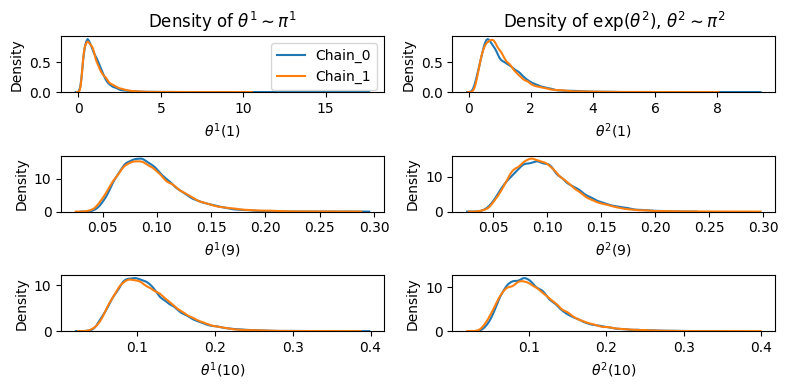

In [19]:
fig ,axs = plt.subplots(nrows=len(path_indices), ncols=2, figsize=(8,4))


for idx, i in enumerate(path_indices):
    sns.kdeplot(chains_MCMC_dict['chain_0'][:,i], ax=axs[idx,0], label='Chain_0')
    sns.kdeplot(chains_MCMC_dict['chain_1'][:,i], ax=axs[idx,0], label='Chain_1')
    sns.kdeplot(chains_not_logspace_dict['chain_0'][:,i], ax=axs[idx,1])
    sns.kdeplot(chains_not_logspace_dict['chain_1'][:,i], ax=axs[idx,1])
    axs[idx,0].set_xlabel(r'$\theta^1(%d)$'%i)
    axs[idx,1].set_xlabel(r'$\theta^2(%d)$'%i)

axs[0,0].legend()
axs[0,0].set_title(r"Density of $\theta^1 \sim \pi^1$")
axs[0,1].set_title(r'Density of $\exp(\theta^2)$, $\theta^2 \sim \pi^2$')

fig.tight_layout()

### Plot 2d densities:

Since the data has very high variance we plot the 2D densities of $ \log{\theta}$ against $x$, where $\theta$ are the MCMC-samples from the benchmark approach and $x$ are the samples (not in logspace) taken from our approach described above. Remember we try to justify that $\exp(x) = \theta$ holds since we want to sample $x$ instead of $\theta$ in logspace.


Text(0.5, 1.0, '2D Density of $\\exp(\\theta^2)$, $\\theta^2 \\sim \\pi^2$')

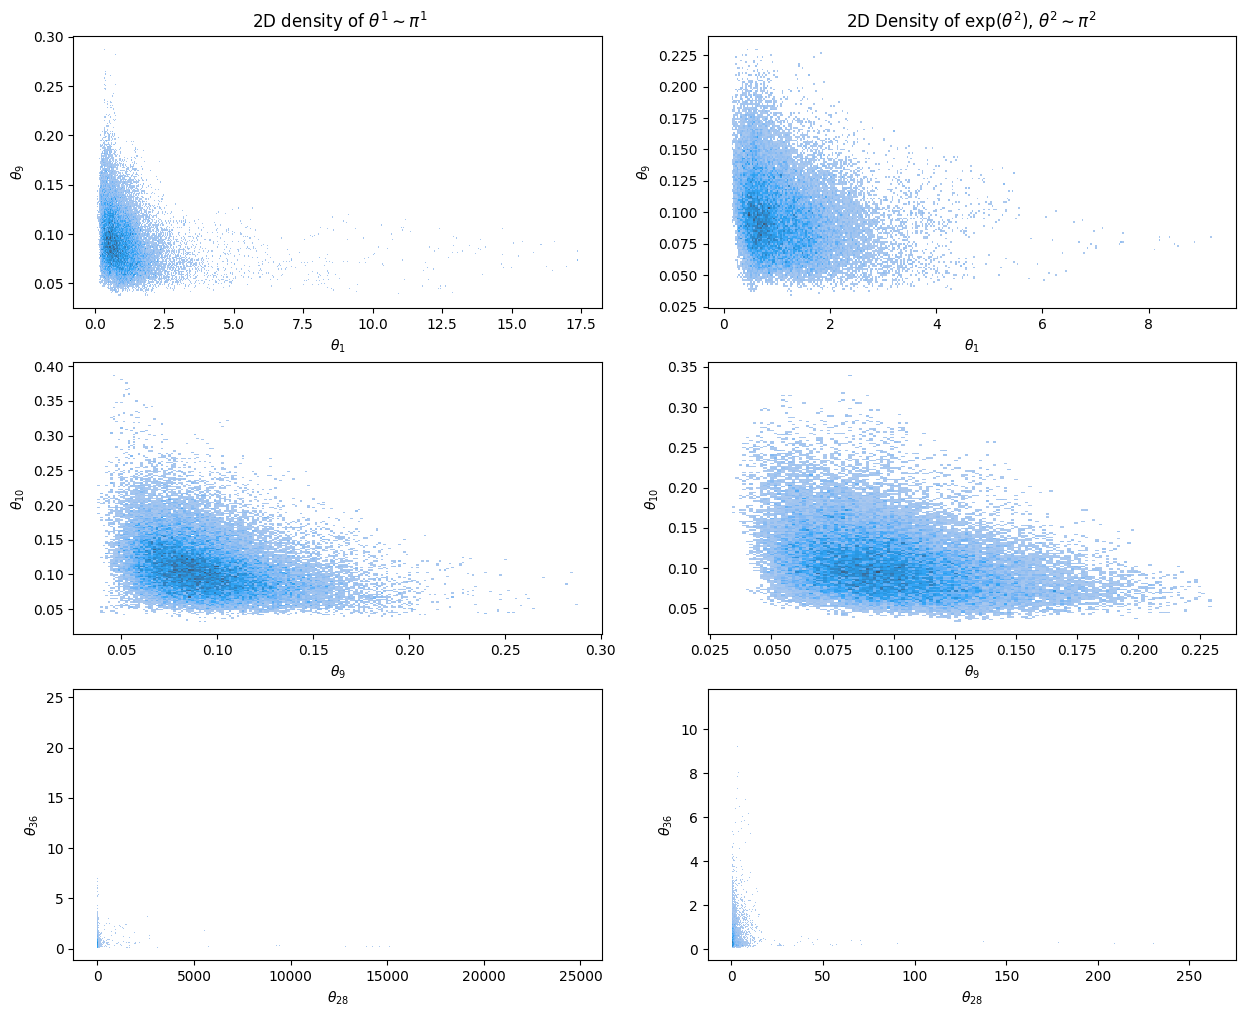

In [8]:
# select pairs of theta indices that should be plotted together
combinations = [[1,9],[9,10],[28,36]] 

fig ,axs = plt.subplots(nrows=len(combinations), ncols=2, figsize=(15,12))


for idx, i in enumerate(combinations):
    sns.histplot(data=pd.DataFrame(chains_MCMC_dict['chain_0'][:,i], columns=['theta_%d'%i[0],'theta_%d'%i[1]]),
                x='theta_%d'%i[0], y='theta_%d'%i[1], ax=axs[idx,0])
    sns.histplot(data=pd.DataFrame(chains_not_logspace_dict['chain_0'][:,i], columns=['theta_%d'%i[0],'theta_%d'%i[1]]),
                x='theta_%d'%i[0], y='theta_%d'%i[1], ax=axs[idx,1])

    axs[idx,0].set_xlabel(r'$\theta_{%d}$'%i[0])
    axs[idx,0].set_ylabel(r'$\theta_{%d}$'%i[1])
    axs[idx,1].set_xlabel(r'$\theta_{%d}$'%i[0])
    axs[idx,1].set_ylabel(r'$\theta_{%d}$'%i[1])
    
axs[0,0].set_title(r" 2D density of $\theta^1 \sim \pi^1$")
axs[0,1].set_title(r'2D Density of $\exp(\theta^2)$, $\theta^2 \sim \pi^2$')


### Plot mean:

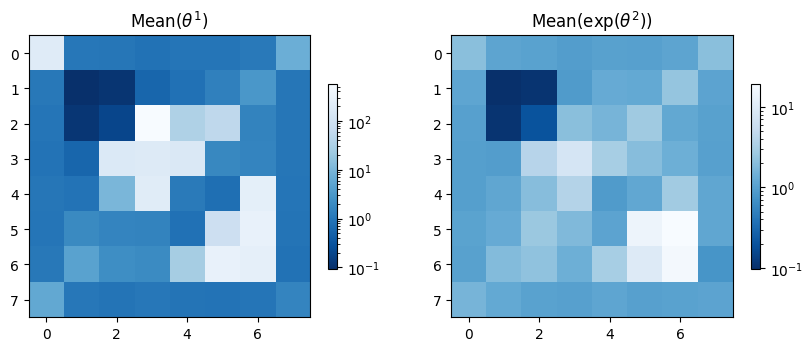

In [10]:
post_MCMC = chains_MCMC.posterior
post_not_logspace = chains_not_logspace.posterior
mean_MCMC = np.reshape(post_MCMC.mean().to_array().to_numpy(), [8,8])
mean_not_logspace = np.reshape(post_not_logspace.mean().to_array().to_numpy(), [8,8])

fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(10,8))


if not plot_log_theta:
    im1 = axs[0].imshow(mean_MCMC, norm=colors.LogNorm(vmin=mean_MCMC.min(), vmax=mean_MCMC.max()), cmap='Blues_r')
    im2 = axs[1].imshow(mean_not_logspace, norm=colors.LogNorm(vmin=mean_not_logspace.min(), vmax=mean_not_logspace.max()), cmap='Blues_r')
    axs[0].set_title(r'Mean($\theta^1$)')
    axs[1].set_title(r'Mean($\exp(\theta^2)$)')
else:
    im1 = axs[0].imshow(mean_MCMC, cmap='Blues_r')
    im2 = axs[1].imshow(mean_not_logspace, cmap='Blues_r')
    axs[0].set_title(r'Mean($\log(\theta^1)$)')
    axs[1].set_title(r'Mean($\theta^2$)')

fig.colorbar(im1,ax=axs[0], shrink=0.3)
fig.colorbar(im2, ax=axs[1], shrink=0.3)

### Plot covariances

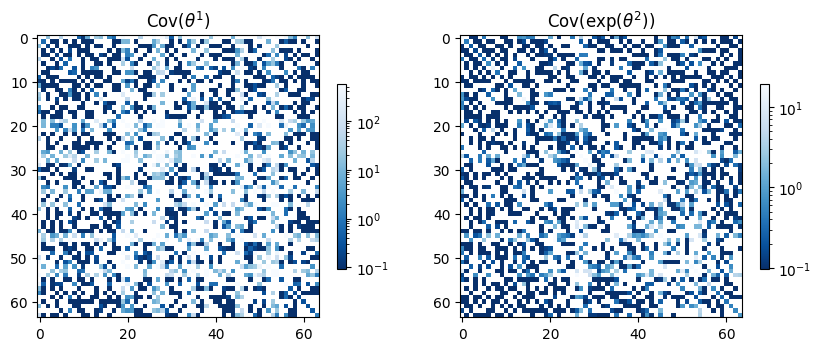

In [14]:
# compute matrix 
num_chains = chains_MCMC_dict['n_chains']
C_benchmark = np.zeros((64,64,num_chains))
C_not_logspace = np.zeros((64,64,num_chains))

# compute covariances for each chain
for n in range(num_chains):
    C_benchmark[:,:,n] = np.cov(chains_MCMC_dict['chain_%d'%n].T)
    C_not_logspace[:,:,n] = np.cov(chains_not_logspace_dict['chain_%d'%n].T)

# compute overall covarianc matrix across all chains
C_b = C_benchmark.mean(axis=2)
C_nlogs = C_not_logspace.mean(axis=2)

# plot results
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(10,8))

if not plot_log_theta:
    im1 = axs[0].imshow(C_b, norm=colors.LogNorm(vmin=mean_MCMC.min(), vmax=mean_MCMC.max()), cmap='Blues_r')
    im2 = axs[1].imshow(C_nlogs, norm=colors.LogNorm(vmin=mean_not_logspace.min(), vmax=mean_not_logspace.max()), cmap='Blues_r')
    axs[0].set_title(r'Cov($\theta^1$)')
    axs[1].set_title(r'Cov($\exp(\theta^2)$)')
else:
    im1 = axs[0].imshow(C_b)
    im2 = axs[1].imshow(C_nlogs)
    axs[0].set_title(r'Cov($\log(\theta^1)$)')
    axs[1].set_title(r'Cov($\theta^2$)')

fig.colorbar(im1,ax=axs[0], shrink=0.3)
fig.colorbar(im2, ax=axs[1], shrink=0.3) 